# Real data

In [1]:
import os; from os import listdir; from os.path import isfile, join
import re  
#from skimage import io 
from skimage.io import imread
# To manipulate arrays
import numpy as np 
import random
from tqdm.notebook import tqdm
from timeit import default_timer as timer
import scipy
import pandas as pd
import shutil
import pathlib
import sys
import rsnapsim as rss

from skimage.exposure import rescale_intensity
# Plotting
import matplotlib as mpl ; import matplotlib.pyplot as plt 
# To create interactive elements
import ipywidgets as widgets ; from ipywidgets import interact, interactive, fixed, interact_manual, Button, HBox, VBox, Layout, GridspecLayout ; from IPython.display import Image
import dna_features_viewer
from dna_features_viewer import BiopythonTranslator, GraphicFeature, GraphicRecord, CircularGraphicRecord

# Deffining directories
current_dir = pathlib.Path().absolute()
sequences_dir = current_dir.parents[1].joinpath('DataBases','gene_files')
video_dir = current_dir.parents[1].joinpath('DataBases','LargeDataSets','20190909_u2os_multiplex','smFLAG-KDM5B')
#video_dir = current_dir.parents[1].joinpath('DataBases','LargeDataSets','20190909_u2os_multiplex','smFLAG-ActB')

rsnaped_dir = current_dir.parents[1].joinpath('rsnaped')

# Importing rSNAPsim_IP
sys.path.append(str(rsnaped_dir))
import rsnaped as rsp


In [2]:
# Paths to dropbox
from sys import platform as _platform
if _platform == "linux" or _platform == "linux2":
    dropbox_address = pathlib.Path('/','home','luisub','Dropbox', 'Project_rSNAPed','manuscript','Figures')
elif _platform == "darwin":
    dropbox_address = pathlib.Path('/','Users','luisaguilera','Dropbox', 'Project_rSNAPed','manuscript','Figures')

In [3]:
#Function to detect all tif files in a folder
def folder_reader(folder):
    '''
    This function imports all tif files in a give folder.
    Input:
    folder: str, with the file name.

    Returns:
    list_files_names :  List of str with all file names
    path_files : List of str with all file paths
    '''
    # Reads the folder with the results and import the simulations as lists
    list_files_names = sorted([f for f in listdir(folder) if isfile(join(folder, f)) and ('.tif') in f], key=str.lower)  # reading all tif files in the folder
    list_files_names.sort(key=lambda f: int(re.sub('\D', '', f)))  # sorting the index in numerical order
    path_files = [ str(folder.joinpath(f).resolve()) for f in list_files_names ] # creating the complete path for each file
    # Reading the microscopy data
    max_frames_to_read = 100
    list_videos = [imread(f)[0:max_frames_to_read,:,:,:] for f in  path_files] # List with all the videos. 
    num_videos = len(path_files) # the number of videos in the folder is the length of list_videos
    return path_files, list_files_names,list_videos, num_videos

In [4]:
# Load gene sequences
path_files,list_files_names,list_videos, num_videos = folder_reader(video_dir)
print(path_files)

['/home/luisub/Desktop/rsnaped/DataBases/LargeDataSets/20190909_u2os_multiplex/smFLAG-KDM5B/MAX_Cell01.tif', '/home/luisub/Desktop/rsnaped/DataBases/LargeDataSets/20190909_u2os_multiplex/smFLAG-KDM5B/MAX_Cell02.tif']


In [5]:
# Coding sequence
#gene_file = str(sequences_dir.joinpath('Bactin_withTags.txt')) # coding sequence for SM_KDM5B_PP7    ### 5685 nt   ### 1895 codons
gene_file= str(sequences_dir.joinpath('KDM5B_withTags.txt'))  # coding sequence for SM_p300_MS2      ### 8268 nt   ### 2756 codons

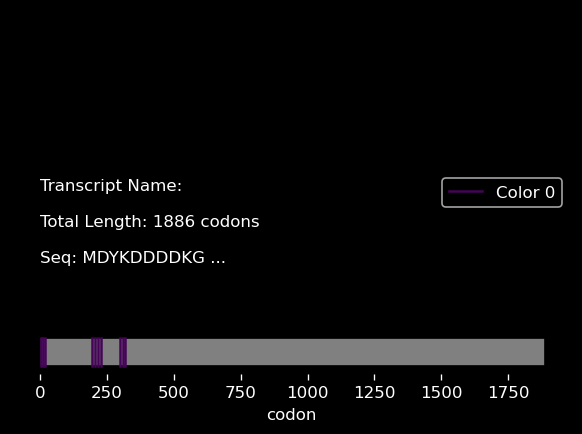

In [6]:
# Simulating a TASEP model for the beta-actin gene
poi_strs, poi_objs, tagged_pois,raw_seq = rss.seqmanip.open_seq_file(gene_file)  #open this file and find all valid protein of interest objs
gene_mrna = tagged_pois['1'][0]  #lets take the first one since thats the longest
rss.solver.protein = gene_mrna #pass this protein object to the solver
gene_mrna.visualize_probe()  # what does our construct look like?

In [7]:
intensity_calculation_method = 'disk_donut'  # options are : 'total_intensity' and 'disk_donut' 'gaussian_fit'
mask_selection_method = 'max_area' # options are : 'max_spots' and 'max_area' 
use_optimization_for_tracking = 0 # 0 not using, 1 is using optimization
#frame_selection_empty_video = 'constant' # Options are: 'constant' , 'shuffle' and 'loop'
#particle_size = 3 # spot size for the simulation and tracking.
particle_detection_size = 5 # spot size for the simulation and tracking.

In [8]:
def plot_original_images(image,slice=0):
    '''
    This function plots all the channels for the original image.
    '''
    number_channels = image.shape[3]
    fig, axes = plt.subplots(nrows=1, ncols=number_channels, figsize=(15, 5))
    for i in range (0,number_channels ):
        img_2d = image[slice,:,:,i]
        img_2d_rescaled = rsp.RemoveExtrema(img_2d, min_percentile = 0.5, max_percentile= 99.5, selected_channels=[0,1]).remove_outliers()
        axes[i].imshow(img_2d_rescaled, cmap='viridis') 
        axes[i].set_title('Channel_'+str(i))
    plt.show()

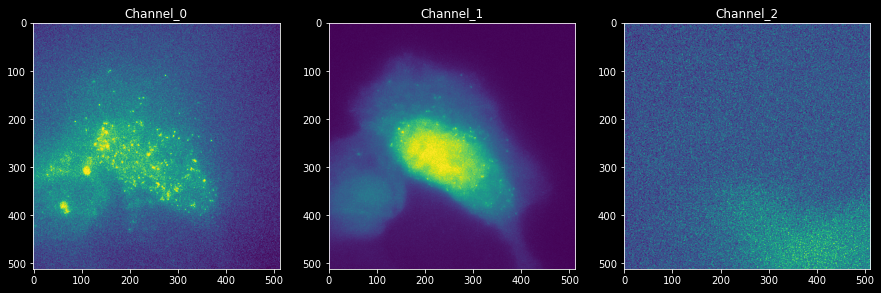

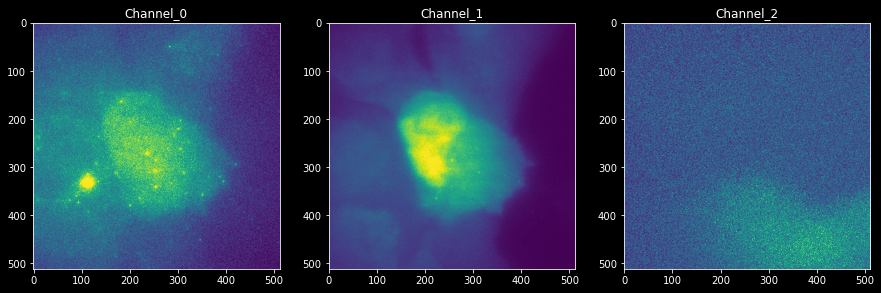

In [9]:
plot_original_images(list_videos[0])
plot_original_images(list_videos[1])

mask time: 7  sec
tracking time: 7  sec
intensity calculation time: 49  sec


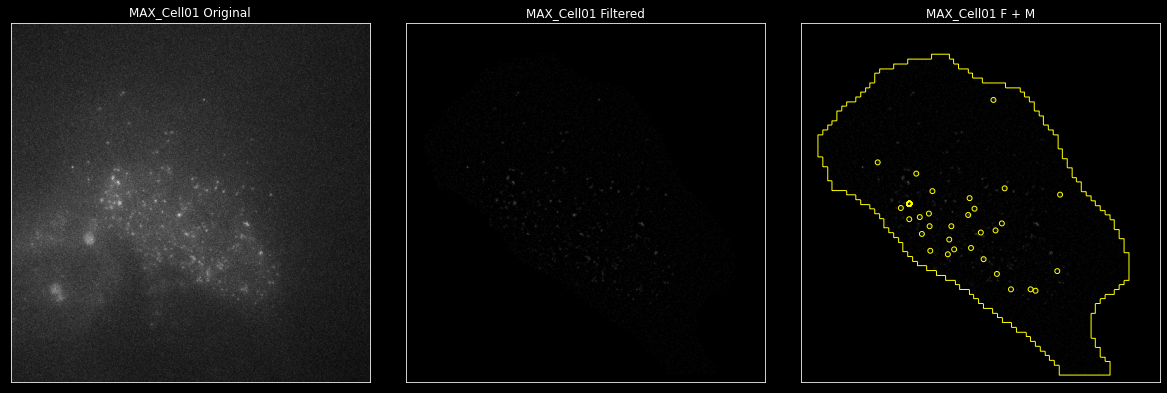

mask time: 5  sec
tracking time: 5  sec
intensity calculation time: 1  sec


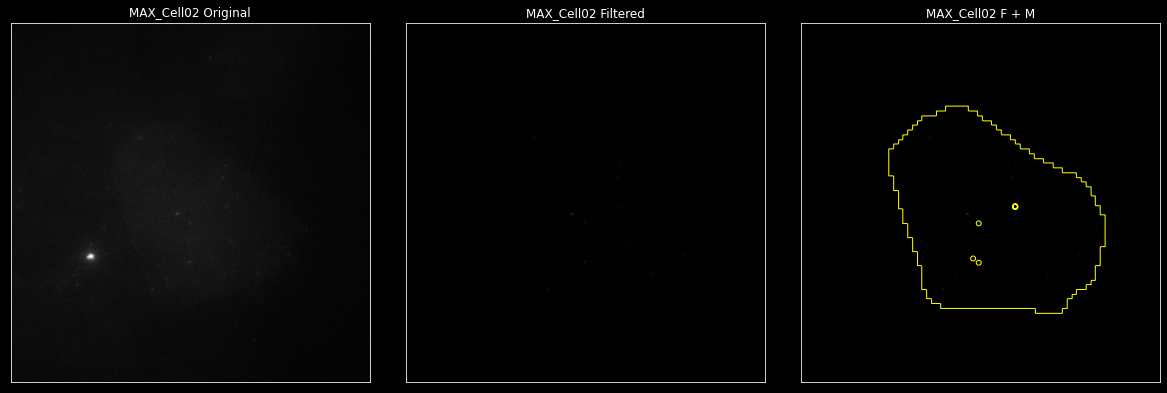

In [10]:
list_DataFrame_particles_intensities= []
for i, temp_video in enumerate(list_videos):
    DataFrame_particles_intensities, _, _, _,_, _, _ = rsp.PipelineTracking(temp_video,particle_size=particle_detection_size,file_name=list_files_names[i],selected_channel=0,intensity_calculation_method =intensity_calculation_method, mask_selection_method = mask_selection_method,show_plot=1,use_optimization_for_tracking=use_optimization_for_tracking,real_positions_dataframe = None, average_cell_diameter=200, print_process_times=1).run()    
    list_DataFrame_particles_intensities.append(DataFrame_particles_intensities)

In [11]:
all_data = True
sel_timepoint = 0
sel_cell = 0

In [12]:
df =list_DataFrame_particles_intensities[sel_cell]
df

,cell_number,particle,frame,red_int_mean,green_int_mean,blue_int_mean,red_int_std,green_int_std,blue_int_std,x,y,SNR_red,SNR_green,SNR_blue,background_int_mean_red,background_int_mean_green,background_int_mean_blue,background_int_std_red,background_int_std_green,background_int_std_blue
0,0,0,0,86.099998,156.240005,0.00,84.982351,495.453593,25.152336,209.792603,329.316896,1.065528,0.351981,-0.108470,923.482117,5031.643066,573.714294,71.436783,720.484863,26.867210
1,0,0,1,90.080002,128.660004,0.00,117.680218,522.270174,21.046463,208.973741,329.066988,1.022213,0.246379,-0.123854,942.321411,5169.696289,571.321411,70.199234,724.345703,27.463034
2,0,0,2,105.739998,15.700000,4.48,111.258359,396.003434,31.986397,210.662993,328.966937,1.324760,0.184810,0.011181,931.857117,5351.035645,575.071411,68.225838,563.630676,36.543934
3,0,0,3,128.740005,171.419998,10.90,116.096264,576.142685,22.717394,212.046106,328.920770,1.642269,0.263321,0.263613,946.928589,5429.500000,562.178589,68.996857,620.612000,27.394020
4,0,0,4,83.419998,282.839996,3.52,109.112390,439.071172,23.329158,211.934929,327.141191,1.312683,0.303750,0.073993,944.964294,5428.821289,569.464294,60.148319,609.115417,27.782293
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4984,0,96,95,0.000000,284.200012,3.38,54.325007,589.144940,37.534326,276.204397,348.941176,-0.605792,0.360117,-0.042363,943.339294,6088.696289,581.446411,69.164467,440.144531,36.976303
4985,0,96,96,6.160000,0.000000,0.00,59.618574,269.842194,36.916121,277.976998,349.833528,-0.109102,-0.476218,-0.347262,914.589294,5894.339355,590.375000,68.094940,404.981232,38.515564
4986,0,96,97,1.300000,248.559998,12.48,50.121452,336.433302,37.017963,277.102291,349.000323,0.052659,0.393032,-0.051664,909.035706,5828.375000,581.464294,52.494202,374.485687,38.407574
4987,0,96,98,0.000000,0.000000,5.00,60.641821,368.491967,33.198795,277.734934,348.953821,-0.153352,-0.307106,-0.073905,936.607117,6096.428711,586.517883,60.300045,566.412720,34.069252


In [13]:
print(list_videos[sel_cell][0,:,:,0].mean())
print(list_videos[sel_cell][0,:,:,1].mean())
print(list_videos[sel_cell][0,:,:,2].mean())

761.118782043457
1997.5076065063477
572.8686141967773


# Plotting figures

In [14]:
fig_size = (20, 5)
f = plt.figure(figsize=fig_size)
def fun_scatter_plot(x,y, title='', xlab='', ylab='',
                alpha=1, color='r',
                subplots=False, show_grid=True, fig=f,font_size=8):
    m, b = np.polyfit(x,y, 1)
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    #axarr = f.add_subplot(1,1,1)
    plt.scatter(x, y, alpha=alpha, color=color, s= 2)
    plt.plot(x, m*x + b,'-w',linewidth=1)
    plt.plot(mean_x,mean_y,'o',color='w' ,  markersize=10)
    plt.xlim(min(x), max(x))
    plt.xlabel(xlab, size=font_size)
    plt.ylabel(ylab, size=font_size)
    plt.grid(show_grid)
    plt.title(title, size=font_size)
    return(f)

<Figure size 1440x360 with 0 Axes>

## Channels

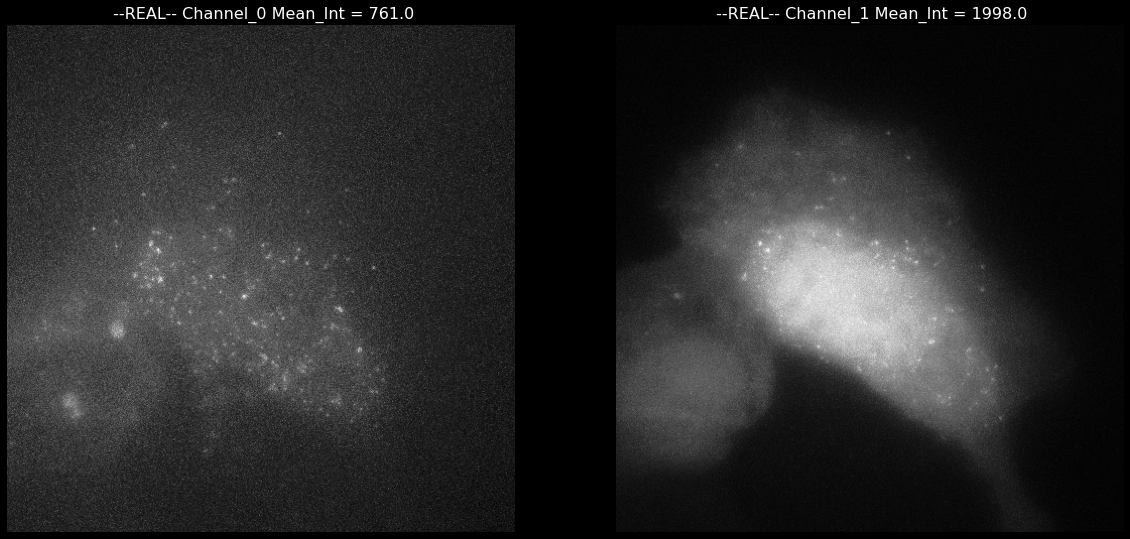

In [15]:
selected_timePoint = 0 # selecting a frame to display in the plot.
fig_size = (20, 10)
fig, ax = plt.subplots(ncols=2,nrows=1, figsize=fig_size)
for i in range(0,2):
  img = list_videos[sel_cell][selected_timePoint,:,:,i]
  mean_int = img.mean()
  #img= rsp.RemoveExtrema(img,min_percentile=1,max_percentile=99.9).remove_outliers()
  ax[i].imshow(img,cmap='Greys_r')
  ax[i].axis('off')
  ax[i].set_title(' --REAL-- Channel_'+str(i) + ' Mean_Int = ' +str(round(mean_int,0)) , size=16)
plt.savefig("./results/real_cell.png")
plt.show()


## Intensity distribution

In [16]:
plt.style.use('ggplot')

In [17]:
fig_size = (14, 2.5)
font_size = 8 



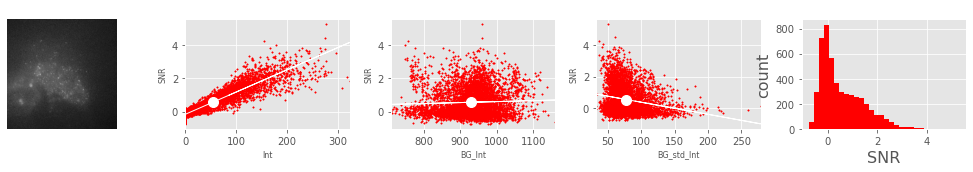

In [18]:
f = plt.figure(figsize=fig_size)

channel = 0
f.add_subplot(1,5,1) 
mean_int = list_videos[0][selected_timePoint,:,:,channel].mean()
plt.imshow(list_videos[0][selected_timePoint,:,:,channel],cmap='Greys_r')
plt.axis('off')
#plt.title(' REAL CH_'+str(channel) + ' mu_Int = ' +str(round(mean_int,0)) , size=16)

f.add_subplot(1,5,2) 
fun_scatter_plot(x = df.red_int_mean.values, y= df.SNR_red.values, title='Int vs SNR', xlab='Int', ylab='SNR', fig=f, color='r')
f.add_subplot(1,5,3) 
fun_scatter_plot(x = df.background_int_mean_red.values, y= df.SNR_red.values, title='BG_Int vs SNR', xlab='BG_Int', ylab='SNR', fig=f, color='r')
f.add_subplot(1,5,4) 
fun_scatter_plot(x = df.background_int_std_red.values, y= df.SNR_red.values, title='BG_std_Int vs SNR', xlab='BG_std_Int', ylab='SNR', fig=f, color='r')

# adding the histogram
f.add_subplot(1,5,5) # here is where you add the subplot to f
f=plt.hist(df.SNR_red.values,bins=30,color='r')
#plt.title('dist SNR', size=16)
plt.ylabel('count', size=16)
plt.xlabel('SNR', size=16)

plt.tight_layout() 
plt.subplots_adjust(wspace=0.25, hspace=0)

name_figure = 'real_SNR_ch0.png'
figure_directory = str(dropbox_address.joinpath(name_figure ) )
plt.savefig(figure_directory, transparent=False,dpi=300, bbox_inches = "tight")

plt.show()

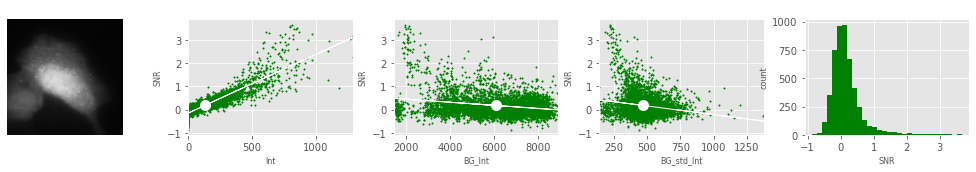

In [19]:
f = plt.figure(figsize=fig_size)

channel = 1
f.add_subplot(1,5,1) 
mean_int = list_videos[0][selected_timePoint,:,:,channel].mean()
plt.imshow(list_videos[0][selected_timePoint,:,:,channel],cmap='Greys_r')
plt.axis('off')
#plt.title(' REAL CH_'+str(channel) + ' mu_Int = ' +str(round(mean_int,0)) , size=16)

f.add_subplot(1,5,2) 
fun_scatter_plot(x = df.green_int_mean.values, y= df.SNR_green.values, title='Int vs SNR', xlab='Int', ylab='SNR', fig=f, color='g',font_size=font_size)
f.add_subplot(1,5,3) 
fun_scatter_plot(x = df.background_int_mean_green.values, y= df.SNR_green.values, title='BG_Int vs SNR', xlab='BG_Int', ylab='SNR', fig=f, color='g',font_size=font_size)
f.add_subplot(1,5,4) 
fun_scatter_plot(x = df.background_int_std_green.values, y= df.SNR_green.values, title='BG_std_Int vs SNR', xlab='BG_std_Int', ylab='SNR', fig=f, color='g',font_size=font_size)

# adding the histogram
f.add_subplot(1,5,5) # here is where you add the subplot to f
f=plt.hist(df.SNR_green.values,bins=30,color='g')
#plt.title('dist SNR', size=16)
plt.ylabel('count', size=font_size)
plt.xlabel('SNR', size=font_size)

plt.tight_layout() 
plt.subplots_adjust(wspace=0.25, hspace=0)

name_figure = 'real_SNR_ch1.png'
figure_directory = str(dropbox_address.joinpath(name_figure ) )
plt.savefig(figure_directory, transparent=True,dpi=300, bbox_inches = "tight")

plt.show()
